<a id="top"></a>
# Wrangling Twitter Data

## Table of Contents
- [Twitter: The Gathering](#thegathering)  
    - [Twitter Archive](#archive_gathering)
    - [Image Predictions](#predictions_gathering)
    - [Tweets Details](#tweets_gathering)
- [Assessing](#data_assessment)
    - [Twitter Archive](#twitter_archive_assessment)
        - [Dataset Overview](#twitter_archive_overview)
        - [Dog Stages](#dog_stage)
        - [Dog Names](#dog_names)
        - [Dataset Statistics](#dataset_statistics)
        - [Dog Ratings](#dog_ratings)
        - [Duplicates](#twitter_archive_duplicates)
    - [Predictions Dataset](#predictions_dataset)
    - [Fetched Tweets Dataset](#fetched_tweets_dataset) 
    - [Assessment Summary](#summary)
        - [Quality](#quality)
        - [Tidiness](#tidiness)
- [Cleaning](#cleaning)    
    - [Image Predictions Data](#predictions_clean)
        - [Issue 1: Incorrect datatype for `tweet_id`](#pc_issue1)
        - [Issue 2: Inconsistent prediction values format (lowercase and uppercase, underscores) in `p1`, `p2`,`p3`](#pc_issue2)
    - [Tweets Details JSON Dataset](#tweets_cleaning)
        - [Issue 1: Incorrect data type for `id`](#tc_issue1)
        - [Issue 2: Incorrect column name - `id` (should be `tweet_id`) ](#tc_issue2)
    - [Twitter Archive Dataset (Core)](#twitter_archive_cleaning)
        - [Issue 1: Incorrect data types for `tweet_id`](#ta_issue1)
        - [Issue 2: Incorrect data type for `timestamp`](#ta_issue2)
        - [Issue 3: Incorrect datatype for doggo, floofer, pupper, puppo](#ta_issue3)
        - [Issue 4: Invalid dog names](#ta_issue4)
        - [Issue 5: Values in source column are inside the 'a' tag](#ta_issue5)        
        - [Issue 6: Incorrect ratings - 1776 and 420, zero rating and no rating](#ta_issue6)
        - [Issue 7: Incorrectly parsed ratings](#ta_issue7)        
        - [Issue 8: Tweets that advertise WeRateDogs stickers   ](#ta_issue8)
        - [Issue 9: Dog stages for pupper and doggo are missing when in fact they are present in text in plural form](#ta_issue9)
        - [Issue 10: One variable (essentially - dog type) in four columns: doggo, floofer, pupper, puppo](#ta_issue10) 
        - [Issue 11: Original tweets are mixed with replies and retweets](#ta_issue11)
        - [Issue 12: Tweets text column contain both text AND links that are expanded in explaned_urls column](#ta_issue12)
        - [Issue 13: `text` column contain both text and unexpanded link](#ta_issue13)
        - [Issue 14: `text` column contain both text and rating](#ta_issue14)
        - [Issue 15: Text contains endline symbol \n and ampersand &amp](#ta_issue15)
        - [Issue 16: Tweets details should be merged with twitter archive](#ta_issue16)
        - [Issue 17: Predictions should be merged with the twitter archive](#ta_issue17)
- [Store Final Dataset](#cleaning_final)
- [Analysis and Visualisation](#analysis)
     - [Number of tweets by weekday by hour](#tweets_by_weekday_hour)
     - [Most popular dog names](#top_names)
     - [Most popular words](#top_words)
- [Conclusion](#conclusion)

<a id="thegathering"></a>
# Twitter: The Gathering
[back to top](#top)

In [2]:
import pandas as pd
import tweepy
import requests
import json
import io
from timeit import default_timer as timer

<a id="archive_gathering"></a>
## Twitter Archive
[back to top](#top)

In [3]:
twitter_archive = pd.read_csv('twitter-archive-enhanced-2.csv')

<a id="predictions_gathering"></a>
## Image Predictions 
[back to top](#top)

In [4]:
response = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
predictions = pd.read_csv(io.StringIO(response.text), sep='\t')   
predictions.to_csv('image-predictions.tsv',sep='\t',index=False)

<a id="tweets_gathering"></a>
## Tweets Details
[back to top](#top)

### Set up authentication

In [5]:
# read credential to json (and add this json to .gitignor so that
# we don't occasionally commit API keys to GitHub)
with open('credentials.json') as json_data:
    credentials = json.load(json_data)

In [6]:
consumer_key = credentials['consumer_key']
consumer_secret = credentials['consumer_secret']
access_token = credentials['access_token']
access_secret = credentials['access_secret']

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth_handler=auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

### Select valid tweets ids
This step appeared during re-iteration. When assessing the data, I found out that we don't have predictions for all of our data. Also, not all the tweets in the core dataframe are actual tweets - some of them are replies and some of them are retweets. We will not be analyzing them, so it doesn't make sense to download data for them. 

In [7]:
# select only original tweets (exclude replies and retweets)
tweet_ids = (twitter_archive[twitter_archive.in_reply_to_status_id.isnull() & 
                             twitter_archive.retweeted_status_id.isnull()].tweet_id)

### Load tweets

In [ ]:
unavailable_tweets = []
start = timer()
with open('tweet_json.txt', 'w') as file:
    for tweet_id in tweet_ids:
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            json.dump(tweet._json, file)
            file.write('\n')
        except tweepy.TweepError as e:
            print("Fail: " + str(tweet_id) + "\n" + str(e))
            unavailable_tweets.append(tweet_id)
            pass
end = timer()
print(end - start)

In [8]:
with open('tweet_json.txt', 'r') as tweets_json:
    fetched_tweets = tweets_json.read()
tweets = pd.read_json(fetched_tweets, lines=True)

In [9]:
tweets.columns

Index(['contributors', 'coordinates', 'created_at', 'display_text_range',
       'entities', 'extended_entities', 'favorite_count', 'favorited',
       'full_text', 'geo', 'id', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status',
       'lang', 'place', 'possibly_sensitive', 'possibly_sensitive_appealable',
       'quoted_status', 'quoted_status_id', 'quoted_status_id_str',
       'quoted_status_permalink', 'retweet_count', 'retweeted', 'source',
       'truncated', 'user'],
      dtype='object')

Out all of these columns we're actually interested only in the following:
- id (to match it with other datasets)
- favorite_count
- retweet_count

In [53]:
tweets = tweets[['id','favorite_count','retweet_count']]

<a id="data_assessment"></a>
# Assessing
[back to top](#top)

The code has short comments about my observations after each operation. However, all the quality and tidiness issues are also documented in the end of this section. 

In [10]:
# essential for displaying texts!
pd.set_option('display.max_colwidth', -1)

<a id="twitter_archive_assessment"></a>
## Twitter Archive Dataset
[back to top](#top)

<a id="twitter_archive_overview"></a>
### Overview
[back to top](#top)

In [11]:
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


**Observations:**

- We can note that there are 4 columns (`doggo`, `floofer`, `pupper`, `puppo`) for essentialy 1 variable - dog type. 

- Also there is a problem with the source column - the link is inside the tag. 

In [12]:
# overview 
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

<a id="dog_stage"></a>
### Timestamp
[back to top](#top)

In [13]:
twitter_archive.head(1)[['tweet_id','timestamp']]

,tweet_id,timestamp
0,892420643555336193,2017-08-01 16:23:56 +0000


If we go to the actual tweet, we'll discover that the real time is 9:23, not 16:23. Looks like the time in our dataframs is in UTC. Although in general it's a great practice to have time in UTC, for analytical purposes it doesn't make sense to have time in UTC.

<a id="dog_stage"></a>
### Dog stage
[back to top](#top)

Let's check one of these `floofer`, `doggo`, `pupper`, `puppo` columns: 

In [14]:
twitter_archive.doggo.value_counts()

None     2259
doggo    97  
Name: doggo, dtype: int64

Even if these four columns were dummy variables for prediction modes, the datatype is still incorrect. Should be boolean. 

In [15]:
no_type = ((twitter_archive.doggo=='None') & 
           (twitter_archive.floofer=='None') & 
           (twitter_archive.pupper=='None') &
           (twitter_archive.puppo=='None'))
no_type.sum()

1976

The majority of dogs are of unrecognized stage - is it really that bad? Can we find any of them? 

In [16]:
twitter_archive[(((twitter_archive.text.str.contains('doggo')) |
                 (twitter_archive.text.str.contains('floofer')) |
                 (twitter_archive.text.str.contains('puppo')) |
                 (twitter_archive.text.str.contains('pupper'))) &
                 no_type)][['doggo','floofer','pupper','puppo','text']]

,doggo,floofer,pupper,puppo,text
54,None,None,None,None,This is Gary. He couldn't miss this puppertunity for a selfie. Flawless focusing skills. 13/10 would boop intensely https://t.co/7CSWCl8I6s
83,None,None,None,None,I can say with the pupmost confidence that the doggos who assisted with this search are heroic as h*ck. 14/10 for all https://t.co/8yoc1CNTsu
85,None,None,None,None,"Meet Venti, a seemingly caffeinated puppoccino. She was just informed the weekend would include walks, pats and scritches. 13/10 much excite https://t.co/ejExJFq3ek"
106,None,None,None,None,Say hello to Lassie. She's celebrating #PrideMonth by being a splendid mix of astute and adorable. Proudly supupporting her owner. 13/10 https://t.co/uK6PNyeh9w
134,None,None,None,None,This is Lili. She can't believe you betrayed her with bath time. Never looking you in the eye again. 12/10 would puppologize profusely https://t.co/9b9J46E86Z
228,None,None,None,None,Jerry just apuppologized to me. He said there was no ill-intent to the slippage. I overreacted I admit. Pupgraded to an 11/10 would pet
268,None,None,None,None,Here we have some incredible doggos for #K9VeteransDay. All brave as h*ck. Salute your dog in solidarity. 14/10 for all https://t.co/SVNMdFqKDL
274,None,None,None,None,@0_kelvin_0 &gt;10/10 is reserved for puppos sorry Kevin
296,None,None,None,None,This is Lucy. She has a portrait of herself on her ear. Excellent for identification pupposes. 13/10 innovative af https://t.co/uNmxbL2lns
302,None,None,None,None,"RT @SchafeBacon2016: @dog_rates Slightly disturbed by the outright profanity, but confident doggos were involved. 11/10, would tailgate aga…"


It looks like we can fill in some of the missing values and then filter out non-dogs with predictions data. Specifically, it will work for puppers and doggos. 

**Observations** 
- Looks like we have several columns that are mostly null. We probabliy shouldn't use these columns in our analysis or rather convert them to some boolean variable that indicates whether the tweet was a reply to something. 
- Also we can see the problem with datatypes: 
    - `timestamp` is object, should be datetime 
    - `tweet_id` is int, should be string 
    - `doggo`, `floofer`, `pupper`, `puppo` are objects, should be boolean columns (if we idnore tidiness issue) 

The column `expanded_urls` looks weird. Let's explore it further. 

In [17]:
twitter_archive.expanded_urls.head(10)

0    https://twitter.com/dog_rates/status/892420643555336193/photo/1                                                                
1    https://twitter.com/dog_rates/status/892177421306343426/photo/1                                                                
2    https://twitter.com/dog_rates/status/891815181378084864/photo/1                                                                
3    https://twitter.com/dog_rates/status/891689557279858688/photo/1                                                                
4    https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1
5    https://twitter.com/dog_rates/status/891087950875897856/photo/1                                                                
6    https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1                    
7    https://twitter.com/dog_rates/status/890729181411237888/photo/1,

And it looks like we have multiple values in one column! Let's check what is the maxiumum number of links in each cell: 

In [18]:
# expande urls
twitter_archive.expanded_urls.astype('str').apply(lambda x: len(x.split(','))).value_counts()

1    1717
2    365 
4    134 
3    120 
5    10  
6    6   
8    4   
Name: expanded_urls, dtype: int64

Looks like some tweets have 8 links!!! But we've seen the dataframe and the links look repetetive. What are the actual counts of distinct links? 

In [19]:
twitter_archive.expanded_urls.astype('str').apply(lambda x: len( set(x.split(',')) )).value_counts()

1    2315
2    41  
Name: expanded_urls, dtype: int64

Let's check what is the source column about:

In [20]:
twitter_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                        91  
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     33  
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    11  
Name: source, dtype: int64

This column is a bit oscure, but I suspect that it indicates the source of traffic. The majority of them is Twitter for iPhone.

<a id="dog_names"></a>
### Dogs names
[back to top](#top)

In [21]:
twitter_archive.name.value_counts().head(20)

None       745
a          55 
Charlie    12 
Lucy       11 
Cooper     11 
Oliver     11 
Penny      10 
Lola       10 
Tucker     10 
Bo         9  
Winston    9  
the        8  
Sadie      8  
Buddy      7  
an         7  
Daisy      7  
Toby       7  
Bailey     7  
Rusty      6  
Stanley    6  
Name: name, dtype: int64

The `name` column looke fine at first sight, but looks like `None` is interpreted as a name, that's why it looks like we don't have any null-values there! Also the name `a` doesn't look valid.

In [22]:
twitter_archive[(twitter_archive.name=='a') | (twitter_archive.name=='an') |
               (twitter_archive.name=='the')][['name','text']].head(10)

,name,text
56,a,Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF
649,a,Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq
759,an,RT @dog_rates: This is an East African Chalupa Seal. We only rate dogs. Please only send in dogs. Thank you... 10/10 https://t.co/iHe6liLwWR
801,a,Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn
1002,a,This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW
1004,a,Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R
1017,a,This is a carrot. We only rate dogs. Please only send in dogs. You all really should know this by now ...11/10 https://t.co/9e48aPrBm2
1025,an,This is an Iraqi Speed Kangaroo. It is not a dog. Please only send in dogs. I'm very angry with all of you ...9/10 https://t.co/5qpBTTpgUt
1049,a,This is a very rare Great Alaskan Bush Pupper. Hard to stumble upon without spooking. 12/10 would pet passionately https://t.co/xOBKCdpzaa
1193,a,People please. This is a Deadly Mediterranean Plop T-Rex. We only rate dogs. Only send in dogs. Thanks you... 11/10 https://t.co/2ATDsgHD4n


In [23]:
twitter_archive[twitter_archive.name=='None'][['name','text']].head()

,name,text
5,None,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh
7,None,When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq
12,None,Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm
24,None,You may not have known you needed to see this today. 13/10 please enjoy (IG: emmylouroo) https://t.co/WZqNqygEyV
25,None,This... is a Jubilant Antarctic House Bear. We only rate dogs. Please only send dogs. Thank you... 12/10 would suffocate in floof https://t.co/4Ad1jzJSdp


Pandas, tacos, carrots??? Our dataset with predictions will probably help us to filter that out. But the names of the dogs are definitely not 'a's. 

We can guess that if it's not a name it will start with some lowercase letter and thus we can find what we should fix/exclude.

In [24]:
twitter_archive[twitter_archive.name.str.contains('^[a-z].*')].name.value_counts()

a               55
the             8 
an              7 
very            5 
one             4 
quite           4 
just            4 
actually        2 
mad             2 
getting         2 
not             2 
space           1 
my              1 
life            1 
this            1 
infuriating     1 
his             1 
by              1 
light           1 
old             1 
officially      1 
such            1 
incredibly      1 
unacceptable    1 
all             1 
Name: name, dtype: int64

<a id="dataset_statistics"></a>
### Dataset statistics 
[back to top](#top)

In [25]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


The first five columns have wrong datatype, but we've already noted that earlier. What's more important is that we have weird values for `rating_numerator` and `rating_denominator`. Based on our knowledge of the domain area, denominator is usually 10 while numerator is usually larger than 10, but still a 2-digit number below 20. Also, we see that 75% of the data is below 12, so there is definitely something wrong with it. 

<a id="dog_ratings"></a>
### Dogs Ratings 
[back to top](#top)

#### Denominators

We expect the denominator to be exactly 10, so what went wrong here? 

##### Denominators lower than 10

In [26]:
twitter_archive[twitter_archive.rating_denominator<10][['tweet_id','rating_numerator','rating_denominator','in_reply_to_status_id','text']]

,tweet_id,rating_numerator,rating_denominator,in_reply_to_status_id,text
313,835246439529840640,960,0,8.352460e+17,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho"
516,810984652412424192,24,7,NaN,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
2335,666287406224695296,1,2,NaN,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv


So we have one tweet which is a reply to some other tweet with valid rating (and after N-th iteration of data assessing) and we're not interested in replies - only original tweets. Another two tweets where something else has been taken as a rating.

##### Denominators larger than 10

In [27]:
# select only original tweets with denominator larger than 10 
denominator_outliers = twitter_archive[(twitter_archive.rating_denominator>10) &
                                       (twitter_archive.in_reply_to_status_id.isnull()) &
                                       (twitter_archive.in_reply_to_user_id.isnull())
                                      ][['tweet_id','rating_numerator','rating_denominator','text']]
denominator_outliers

,tweet_id,rating_numerator,rating_denominator,text
433,820690176645140481,84,70,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
784,775096608509886464,9,11,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…"
902,758467244762497024,165,150,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
1068,740373189193256964,9,11,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ"
1120,731156023742988288,204,170,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
1165,722974582966214656,4,20,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
1202,716439118184652801,50,50,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq
1228,713900603437621249,99,90,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1
1254,710658690886586372,80,80,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12
1274,709198395643068416,45,50,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK"


We can see that too high denominator is often used when the tweet is about multiple dogs, puppies, so it "scales" and if we measure the ratio, we would expect it will stay within the expected range. However, there are also tweets with wrong ratings where, again, something else was taken for a rating: 
- 9/11 is a date (also, there are two 9/11 posts, one of which is a retweet) 
- 7/11 is somerthing else 
- 50/50 is a split
- 4/20 is the ratio of puppies shown

Let's check the situation with retweets:

In [28]:
twitter_archive[twitter_archive.retweeted_status_id.notnull() | twitter_archive.retweeted_status_user_id.notnull()][['tweet_id','in_reply_to_status_id','text']].head()

,tweet_id,in_reply_to_status_id,text
19,888202515573088257,NaN,RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX
32,886054160059072513,NaN,RT @Athletics: 12/10 #BATP https://t.co/WxwJmvjfxo
36,885311592912609280,NaN,RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well https://t.co/SATN4If5H5
68,879130579576475649,NaN,RT @dog_rates: This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved https://…
73,878404777348136964,NaN,"RT @dog_rates: Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps:/…"


I manually checked some of these links - they lead to tweets with different tweet_id that contain the same text. So information is duplicated! For example, tweet 888202515573088257 is pointing to tweet 887473957103951883.

In [29]:
twitter_archive[twitter_archive.tweet_id==887473957103951883]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
23,887473957103951883,NaN,NaN,2017-07-19 00:47:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1",13,10,Canela,None,None,None,None


The number of retweets (catching them all):

In [30]:
twitter_archive.text.str.startswith("RT").sum()
retweet = (twitter_archive.retweeted_status_id.notnull() | 
           twitter_archive.retweeted_status_user_id.notnull() | 
           twitter_archive.text.str.startswith("RT") |
           twitter_archive.text.str.startswith("Retweet"))
retweet.sum()

184

#### Numerators 

Now it's time to check the numerators. We've already identified several issues: retweets, replies, multidog issue. What does numerators add to this? First, we should e

In [31]:
exclude_replies = (twitter_archive.in_reply_to_status_id.isnull()) & (twitter_archive.in_reply_to_user_id.isnull())
# idenfity puppies by normal ratio
puppies = ((twitter_archive.rating_numerator/twitter_archive.rating_denominator < 2) & 
           (twitter_archive.rating_denominator > 15))

##### Puppies

Now, lets's find the puppies:

In [32]:
twitter_archive[puppies&exclude_replies][['tweet_id','text']]

,tweet_id,text
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK"
1351,704054845121142784,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa
1433,697463031882764288,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ


Okay, now we can exclude replies and puppies and check other outlier dogs: 

##### Outliers but not puppies

In [33]:
twitter_archive[exclude_replies&(~puppies)&(~retweet)&(twitter_archive.rating_numerator>20)][['tweet_id','rating_numerator','rating_denominator','text']]

,tweet_id,rating_numerator,rating_denominator,text
516,810984652412424192,24,7,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
695,786709082849828864,75,10,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS"
763,778027034220126208,27,10,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq
979,749981277374128128,1776,10,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh
1712,680494726643068929,26,10,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD
2074,670842764863651840,420,10,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY


Now we have to check really few tweets (in the first iteration I had to check MUCH more tweets until I find patterns for anomalies - puppies, retweets, replies).  
Okay, now we have incorrectly recognized values: 
- 24/7 - we've seen it before and already reported
- 27/10, 26/10, 75/10 - incorrectly recognized rating (looks like, integer is wrong datatype for this column)

1776 and 420 are to super special dogs, let's look at these: 

What about the rest? 

In [34]:
%%html
<img src='rating1776.jpg' style="float: left; width: 40%; margin-right: 1%;">
<img src='rating420.jpg' style="float: left; width: 40%; margin-right: 1%;">

As we can see, the data was parsed correctly, but the thing is that 1776 and 420 don't make sense for EDA. 

##### Low ratings - not good boys? 

In [35]:
twitter_archive[exclude_replies&(~puppies)&(~retweet)&(twitter_archive.rating_numerator<10)][['tweet_id','rating_numerator','rating_denominator','text']].head()

,tweet_id,rating_numerator,rating_denominator,text
45,883482846933004288,5,10,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948"
229,848212111729840128,6,10,"This is Jerry. He's doing a distinguished tongue slip. Slightly patronizing tbh. You think you're better than us, Jerry? 6/10 hold me back https://t.co/DkOBbwulw1"
315,835152434251116546,0,10,When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag
730,781661882474196992,5,10,Who keeps sending in pictures without dogs in them? This needs to stop. 5/10 for the mediocre road https://t.co/ELqelxWMrC
765,777885040357281792,3,10,This is Wesley. He's clearly trespassing. Seems rather h*ckin violent too. Weaponized forehead. 3/10 wouldn't let in https://t.co/pL7wbMRW7M


In [36]:
(exclude_replies&(~puppies)&(~retweet)&(twitter_archive.rating_numerator<5)).sum()

49

We have 49 dogs with rating lower than 10. I checked a few tweets randomly and sometimes it's not even a dog (it can be a carrot, a goat, a plastic figure), but mostly these are still ratings. Some of them will be fileterd out by the neural networks as not-dogs. However, there is one case we need to address here - rating of 0: 

In [37]:
twitter_archive[exclude_replies&
                (~puppies)&
                (~retweet)&
                (twitter_archive.rating_numerator==0)][['tweet_id',
                                                        'rating_numerator',
                                                        'rating_denominator',
                                                        'text']]

,tweet_id,rating_numerator,rating_denominator,text
315,835152434251116546,0,10,When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag


In [38]:
%%html
<img src='rating0.jpg' width=300px>

This tweet looks totally out of place - it's not a  dog rating. 

<a id="twitter_archive_duplicates"></a>
### Check for duplicates
[back to top](#top)

In [39]:
twitter_archive.duplicated().sum()

0

In [40]:
twitter_archive.tweet_id.duplicated().sum()

0

In [41]:
twitter_archive.expanded_urls.duplicated().sum()

137

Let's check that we're not dealing with retweets and replies here: 

In [42]:
valid_tweets = twitter_archive[twitter_archive.expanded_urls.notnull()&
                                               (~retweet)&
                                               exclude_replies]
valid_tweets[valid_tweets.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


Okay, these were replies, so we can safely ignore these duplicated links.

<a id="predictions_dataset"></a>
## Predictions Dataset
[back to top](#top)

In [43]:
predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [44]:
len(twitter_archive)- len(predictions)

281

Missing values! Looks like we don't have predictions for 281 tweets!

However, we already know that some of the tweets are actually replies and retweets. So, what is the actual difference? 

In [45]:
len(twitter_archive[twitter_archive.in_reply_to_status_id.isnull() & twitter_archive.retweeted_status_id.isnull()])-len(predictions)

22

We have only 22 missing predictions if we exclude the broadest category of invalid tweets. 

In [46]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [47]:
predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


Probabilites are withing valid range: no negative values, no values greater than 1. Looks valid!

In [48]:
predictions.p1.value_counts().head(20)

golden_retriever             150
Labrador_retriever           100
Pembroke                     89 
Chihuahua                    83 
pug                          57 
chow                         44 
Samoyed                      43 
toy_poodle                   39 
Pomeranian                   38 
cocker_spaniel               30 
malamute                     30 
French_bulldog               26 
miniature_pinscher           23 
Chesapeake_Bay_retriever     23 
seat_belt                    22 
Siberian_husky               20 
German_shepherd              20 
Staffordshire_bullterrier    20 
Cardigan                     19 
web_site                     19 
Name: p1, dtype: int64

<a id="fetched_tweets_dataset"></a>
## Fetched Twitter Data
[back to top](#top)

In [54]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2095 entries, 0 to 2094
Data columns (total 3 columns):
id                2095 non-null int64
favorite_count    2095 non-null int64
retweet_count     2095 non-null int64
dtypes: int64(3)
memory usage: 49.2 KB


We see that we will not be able to merge this dataset with the other two: we need to change the column name first so that we can match it to tweet_id column. Also, id has datatype of integer which is incorrect to use with the ids. 

<a id="summary"></a>
# Assessment Summary
[back to top](#top)
## Quality
<a id="quality"></a>
### Twitter Archive (given by Udacity)
- Incorrect data type for tweet_id - should be string, since operations like adding, subtracting, multiplying don't make sense on ids 
- Incorrect data type for `timestamp`  
- Incorrect timestamps (converted to UTC) - doesn't make sense for analytics  
- Incorrect datatype for `doggo`, `floofer`, `pupper`, `puppo`. 
- Incorrect datatype for numerator (in case we include decimal ratings that sometimes are used in this twitter)
- Invalid dog names: 745 dogs have name 'None' as a string. 55 dogs have name 'a', some have name 'an' and 'the' and other inacceptable names! 
- Values in `source` column are inside the `<a>` tag 

 
- Incorrect ratings: 
    - 4- and 3-digit ratings where numerator means something more than a number: 
        - rating of 1776 (in memory of (Declaration of Independence year) for tweet 749981277374128128  
        - rating of 420 for Snoop dog
    - puppies have weird ratings making it hard to compare to others: 
        - rating of 99/90 for 9 puppies (tweet 713900603437621249)
        - rating of 88/80 for 8 puppies (tweet 675853064436391936)
        - rating of 84/70 for puppies (tweet 820690176645140481) 
        - rating of 80/80 for puppies (tweet 710658690886586372)
        - rating of 45/50 for multiple dogs (tweet 709198395643068416)
        - rating of 60/50 for puppies (tweet 704054845121142784) 
        - rating of 44/40 for puppies (tweet 697463031882764288) 
        - rating of 165/150 for puppies (tweet 758467244762497024)
        - rating of 143/130 for puppies (tweet 684225744407494656) + it's a reply to 684225744407494656 (with puppies that get 121/110) 
        - rating of 144/120 for puppies (tweet 677716515794329600) 
        - rating of 204/170 for multiple dogs (tweet 731156023742988288)
    - incorrectly parsed ratings: 
        - tweet 832215909146226688 has incorrect rating: 75/10 instead of 9.75/10
        - tweet 778027034220126208 has incorrect rating: 27/10 instead of 11.27/10
        - tweet 716439118184652801 has incorrect rating: 50/50 instead of 11/10 (50/50 is about split) 
        - tweet 680494726643068929 has incorrect rating:  instead of 11.26/10
        - tweet 666287406224695296 has incorrect rating: 1/2 instead of 9/10
        - tweet 722974582966214656 has incorrect rating: 4/20 instead of 13/10
        - tweet 740373189193256964 has incorrect rating: 9/11 instead of 14/10
        - tweet 682962037429899265 has incorrect rating: 7/11 instead of 10/10  
        - tweets 883482846933004288 has incorrect rating: 5/10 instead of 13.5/10
    - tweets with no ratings at all: 
        - tweet 810984652412424192 is not rating: 24/7 is not rating 
        - tweet 832088576586297345	is not a rating: 15/11 is date, not rating
    - tweet 835152434251116546 with rating 0/10 is a complaint about plagiarism
    - dogs are mixed with carrots and tacos 
    - dog stages for pupper and doggo are missing when in fact they are present in text in plural form
    - two tweets advertise stickers rather than rate dogs 

### Predictions Dataset (provided by Udacity)
- Missing predictions for 281 tweets
- Incorrect datatype for tweet_id (should be string) 
- Inconsistent prediction values format (some are all lowerscase, some are capitalized, some are with underscores)

### Tweets JSON 
- missing tweets 754011816964026368 and 680055455951884288
- incorrect datatype for column 'id'. 
- incorrect column name for column 'id' (should be 'tweet_id') 

<a id="tidiness"></a>
## Tidiness
[back to top](#top)

### Twitter Archive (given by Udacity)
- One variable (essentially - dog type) in four columns: `doggo`, `floofer`, `pupper`, `puppo`  
- Multiple values in one column in `expanded_urls` column  
- Original tweets are mixed with replies that also bring inconsistency to ratings 
- Retweets are mixed with original tweets (retweets start with RT or Retweet, 184 total retweets) 
- `text` column includes links that are expanded in `explaned_urls` column 
- `text` column includes rating which are already extracted (two variables in one column)
- Links in `expanded links` column are often duplicated. 
- Source and source links are in one column 

### Predictions Dataset (provided by Udacity)
- Predictions should be merged with twitter archive

### Tweets JSON (fetched from Twitter)
- Tweets data should be merged with twitter archive 

<a id="cleaning"></a>
# Cleaning
[back to top](#top)  
[back to issues list](#summary)

In [55]:
twitter_archive_cleaned = twitter_archive.copy()
predictions_cleaned = predictions.copy()
tweets_cleaned = tweets[['id','favorite_count','retweet_count']].copy()

I will start cleaning with the easiest datasets because they will be used with the main dataset. 

<a id="predictions_clean"></a>
## Image Predictions
[back to top](#top)  
[back to issues list](#summary)

<a id="pc_issue1"></a>
### Issue 1: Incorrect datatype for tweet_id 
[back to top](#top)  
[back to issues list](#summary)

#### Define: 
Convert tweet_id column from int to str

#### Code

In [56]:
predictions_cleaned.tweet_id = predictions_cleaned.tweet_id.astype(str)

#### Test

In [57]:
type(predictions_cleaned.tweet_id[0])

str

<a id="pc_issue2"></a>
### Issue 2: Inconsistent prediction values format (lowercase and uppercase, underscores) in `p1`, `p2`,`p3`
[back to top](#top)  
[back to issues list](#summary)

#### Define: 
Replace underscores ('\_') with spaces and capitalize first letter.

#### Code

In [58]:
predictions_cleaned.p1 = predictions_cleaned.p1.str.replace('_', " ").str.capitalize()
predictions_cleaned.p2 = predictions_cleaned.p2.str.replace('_', " ").str.capitalize()
predictions_cleaned.p3 = predictions_cleaned.p3.str.replace('_', " ").str.capitalize()

#### Test

In [59]:
predictions_cleaned[['p1','p2','p3']].head()

,p1,p2,p3
0,Welsh springer spaniel,Collie,Shetland sheepdog
1,Redbone,Miniature pinscher,Rhodesian ridgeback
2,German shepherd,Malinois,Bloodhound
3,Rhodesian ridgeback,Redbone,Miniature pinscher
4,Miniature pinscher,Rottweiler,Doberman


<a id="tweets_cleaning"></a>
## Tweets Details (JSON)
[back to top](#top)  
[back to issues list](#summary)

<a id="tc_issue1"></a>
### Issue 1: Incorrect data type for `id`
[back to top](#top)   
[back to issues list](#summary)

#### Define: 
Convert `id` from int to str

#### Code

In [60]:
tweets_cleaned.id = tweets_cleaned.id.astype('str')

#### Test

In [61]:
type(tweets_cleaned.id[0])

str

<a id="tc_issue2"></a>
### Issue 2: Incorrect column name - `id` (should be `tweet_id`)
[back to top](#top)  
[back to issues list](#summary)

#### Define: 
Rename id to tweet_id

#### Code

In [62]:
tweets_cleaned.rename(columns={'id':'tweet_id'}, inplace=True)

#### Test

In [63]:
tweets_cleaned.columns

Index(['tweet_id', 'favorite_count', 'retweet_count'], dtype='object')

<a id="twitter_archive_cleaning"></a>
## Twitter Archive 
[back to top](#top)  
[back to issues list](#summary)

<a id="ta_issue1"></a>
### Issue 1: Incorrect data types for `tweet_id`
[back to top](#top)

#### Define: 
Convert tweet_id datatype to string 

#### Code:

In [64]:
twitter_archive_cleaned.tweet_id = twitter_archive_cleaned.tweet_id.astype(str)

#### Test

In [65]:
type(twitter_archive_cleaned.tweet_id[0])

str

<a id="ta_issue2"></a>
### Issue 2: Incorrect values and incorrect type for `timestamp`
[back to top](#top)  
[back to issues list](#summary)

#### Define: 
Convert timestamp from string to datetime series

#### Code:

In [66]:
twitter_archive_cleaned['timestamp'] = (pd.to_datetime(
    twitter_archive_cleaned.timestamp,utc=True).dt.tz_convert('US/Pacific'))

#### Test

In [67]:
# the time of the first tweet must be 9:23
twitter_archive_cleaned.timestamp[0]

Timestamp('2017-08-01 09:23:56-0700', tz='US/Pacific')

<a id="ta_issue3"></a>
### Issue 3: Incorrect datatype for `doggo`, `floofer`, `pupper`, `puppo`
[back to top](#top)  
[back to issues list](#summary)

#### Define:
Convert columns doggo, floofer, pupper and pupper to boolean variables, where 1 indicates that the observation is associated with the name of the column. 

#### Code 

In [68]:
twitter_archive_cleaned.doggo = twitter_archive_cleaned.doggo!='None'
twitter_archive_cleaned.floofer = twitter_archive_cleaned.floofer!='None'
twitter_archive_cleaned.pupper = twitter_archive_cleaned.pupper!='None'
twitter_archive_cleaned.puppo = twitter_archive_cleaned.puppo!='None'

#### Test

In [69]:
[twitter_archive_cleaned.doggo.head(1),
 twitter_archive_cleaned.floofer.head(1),
twitter_archive_cleaned.pupper.head(1),
twitter_archive_cleaned.puppo.head(1)]

[0    False
 Name: doggo, dtype: bool, 0    False
 Name: floofer, dtype: bool, 0    False
 Name: pupper, dtype: bool, 0    False
 Name: puppo, dtype: bool]

<a id="ta_issue4"></a>
### Issue 4: Invalid dog names
[back to top](#top)  
[back to issues list](#summary)

#### Define
Replace invalid dog names and dog names equal to 'None' with nulls

#### Code

In [70]:
invalid_names=list(twitter_archive_cleaned[twitter_archive_cleaned.name.
                                           str.contains('^[a-z].*')].
                   name.value_counts().index) + ['None']
twitter_archive_cleaned.loc[twitter_archive_cleaned.name.apply(lambda x: x in invalid_names),'name']=None

#### Test

In [71]:
(twitter_archive_cleaned.name=='None').sum()

0

In [72]:
(twitter_archive_cleaned.name=='a').sum()

0

In [73]:
(twitter_archive_cleaned.name.apply(lambda x: x in invalid_names)).sum()

0

<a id="ta_issue5"></a>
### Issue 5: Values in `source` column are inside the `<a>` tag, two variable in one column 
[back to top](#top)  
[back to issues list](#summary)

#### Define: 
Extract the content between opening and closing tag using regular expressions. Extract the link. Replace `source` variable in the dataset with just the source name and create additional table with source link that we could use as a lookup table. 

#### Code

In [74]:
source_link = twitter_archive_cleaned.source.str.extract(r'<a href="(.+)" .+>', expand=False)
source = twitter_archive_cleaned.source.str.extract(r'>([A-z -]+)<', expand=False)
twitter_archive_cleaned.source = source

In [75]:
sources = pd.DataFrame({'source': source, 'source_link': source_link})
sources.drop_duplicates(inplace=True)

In [76]:
sources

,source,source_link
0,Twitter for iPhone,http://twitter.com/download/iphone
209,Twitter Web Client,http://twitter.com
529,Vine - Make a Scene,http://vine.co
972,TweetDeck,https://about.twitter.com/products/tweetdeck


In [77]:
sources.to_csv('sources_links.csv', index=False)

#### Test

In [78]:
twitter_archive_cleaned.source.value_counts()

Twitter for iPhone     2221
Vine - Make a Scene    91  
Twitter Web Client     33  
TweetDeck              11  
Name: source, dtype: int64

<a id="ta_issue6"></a>
### Issue 6: Incorrect ratings - 1776 and 420, zero rating and no rating
[back to top](#top)  
[back to issues list](#summary)

#### Define: 
- Remove one dog (1776) and one Snoop dogg (420) because their ratings don't make sense.
- Remove record with 0 rating (835152434251116546)
- remove tweets 810984652412424192 and 832088576586297345 that have no actual rating

#### Code

In [79]:
# remove 1776 and 420
invalid_ratings_1776_420 = twitter_archive_cleaned[(twitter_archive_cleaned.rating_numerator==1776)|(twitter_archive_cleaned.rating_numerator==420)].index
twitter_archive_cleaned.drop(invalid_ratings_1776_420, inplace=True)

In [80]:
# remove 0/10
invalid_tweets = ['835152434251116546', '810984652412424192', '832088576586297345']
invalid_ratings = twitter_archive_cleaned[twitter_archive_cleaned.tweet_id.apply(lambda x: x in invalid_tweets)].index
twitter_archive_cleaned.drop(invalid_ratings, inplace=True)

#### Test

In [81]:
twitter_archive_cleaned[(twitter_archive_cleaned.rating_numerator==1776)|(twitter_archive_cleaned.rating_numerator==420)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [82]:
twitter_archive_cleaned[twitter_archive_cleaned.tweet_id.apply(lambda x: x in invalid_tweets)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


<a id="ta_issue7"></a>
### Issue 7: Incorrectly parsed ratings
[back to top](#top)   
[back to issues list](#summary)

- tweet 832215909146226688 has incorrect rating: 75/10 instead of 9.75/10
- tweet 778027034220126208 has incorrect rating: 27/10 instead of 11.27/10
- tweet 716439118184652801 has incorrect rating: 50/50 instead of 11/10 (50/50 is about split)
- tweet 680494726643068929 has incorrect rating: instead of 11.26/10
- tweet 666287406224695296 has incorrect rating: 1/2 instead of 9/10
- tweet 722974582966214656 has incorrect rating: 4/20 instead of 13/10
- tweet 740373189193256964 has incorrect rating: 9/11 instead of 14/10
- tweet 682962037429899265 has incorrect rating: 7/11 instead of 10/10

#### Define: 
Replace the existing ratings numerators with correct ones, round non-integer ratings (they don't make sense and there are only a few of them) to the nearest integer. Replace corresponding denominators with 10. 

#### Code

In [83]:
ratings_fix = {
    '832215909146226688': 10,
    '778027034220126208': 11,
    '716439118184652801': 11,
    '680494726643068929': 11,
    '666287406224695296': 9,
    '722974582966214656': 13,
    '740373189193256964': 14,
    '682962037429899265': 10,
    '883482846933004288': 13}
for key, value in ratings_fix.items():
    twitter_archive_cleaned.loc[twitter_archive_cleaned.tweet_id==key,'rating_numerator'] = value
    twitter_archive_cleaned.loc[twitter_archive_cleaned.tweet_id==key,'rating_denominator'] = 10

#### Test

In [84]:
fixed_tweets = twitter_archive_cleaned.tweet_id.apply(lambda x: x in ratings_fix.keys())
twitter_archive_cleaned[fixed_tweets][['tweet_id','rating_numerator','rating_denominator']]

,tweet_id,rating_numerator,rating_denominator
45,883482846933004288,13,10
340,832215909146226688,10,10
763,778027034220126208,11,10
1068,740373189193256964,14,10
1165,722974582966214656,13,10
1202,716439118184652801,11,10
1662,682962037429899265,10,10
1712,680494726643068929,11,10
2335,666287406224695296,9,10


<a id="ta_issue8"></a>
### Issue 8: Tweets that advertise WeRateDogs stickers  
[back to top](#top)  
[back to issues list](#summary)

#### Define:
Remove tweets that advertise WeRateDogs stickers

#### Code:

In [85]:
# define function that returns bolean Series indicates whether text column contains the given string
text_contains = lambda x: twitter_archive_cleaned.text.str.contains(x)

In [86]:
twitter_archive_cleaned[text_contains('stickers')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1237,712309440758808576,NaN,NaN,2016-03-22 09:06:19-07:00,Twitter for iPhone,"Reminder that we made our first set of stickers available! All are 12/10 would stick\nUse code ""pupper"" at checkout🐶\n\nhttps://t.co/kJIMNyMNKV",NaN,NaN,NaN,https://twitter.com/stickergrub/status/709919141004595201,12,10,None,False,False,True,False
1265,709901256215666688,NaN,NaN,2016-03-15 17:37:03-07:00,Twitter for iPhone,"WeRateDogs stickers are here and they're 12/10! Use code ""puppers"" at checkout 🐶🐾\n\nShop now: https://t.co/k5xsufRKYm https://t.co/ShXk46V13r",NaN,NaN,NaN,"http://goo.gl/ArWZfi,https://twitter.com/dog_rates/status/709901256215666688/photo/1,https://twitter.com/dog_rates/status/709901256215666688/photo/1,https://twitter.com/dog_rates/status/709901256215666688/photo/1,https://twitter.com/dog_rates/status/709901256215666688/photo/1",12,10,None,False,False,False,False


In [87]:
twitter_archive_cleaned.drop(twitter_archive_cleaned[text_contains('stickers')].index, inplace=True)

#### Test

In [88]:
twitter_archive_cleaned[text_contains('stickers')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


<a id="ta_issue9"></a>
### Issue 9: Dog stages for pupper and doggo are missing when in fact they are present in text in plural form
[back to top](#top)  
[back to issues list](#summary)

#### Define
Identify tweets that have doggos and puppers and set corresponding variables (doggo or pupper) to True for these records. 

#### Code 

In [89]:
#any_dog = twitter_archive_cleaned.doggo | twitter_archive_cleaned.pupper | twitter_archive_cleaned.puppo | twitter_archive_cleaned.floofer
unidentified_doggos = (~twitter_archive_cleaned.doggo)&(text_contains('doggos'))
twitter_archive_cleaned[unidentified_doggos][['doggo','text']]

,doggo,text
83,False,I can say with the pupmost confidence that the doggos who assisted with this search are heroic as h*ck. 14/10 for all https://t.co/8yoc1CNTsu
268,False,Here we have some incredible doggos for #K9VeteransDay. All brave as h*ck. Salute your dog in solidarity. 14/10 for all https://t.co/SVNMdFqKDL
302,False,"RT @SchafeBacon2016: @dog_rates Slightly disturbed by the outright profanity, but confident doggos were involved. 11/10, would tailgate aga…"
475,False,RT @dog_rates: Meet Jack. He's one of the rare doggos that doesn't mind baths. 11/10 click the link to see how you can help Jack!\n\nhttps://…
477,False,Meet Jack. He's one of the rare doggos that doesn't mind baths. 11/10 click the link to see how you can help Jack!\n\nhttps://t.co/r4W111FzAq https://t.co/fQpYuMKG3p
798,False,You need to watch these two doggos argue through a cat door. Both 11/10 https://t.co/qEP31epKEV
934,False,Here we are witnessing an isolated squad of bouncing doggos. Unbelievably rare for this time of year. 11/10 for all https://t.co/CCdlwiTwQf
946,False,Here are three doggos completely misjudging an airborne stick. Decent efforts tho. All 9/10 https://t.co/HCXQL4fGVZ
987,False,This is Dietrich. He hops at random. Other doggos don't understand him. It upsets him greatly. 8/10 would comfort https://t.co/U8cSRz8wzC
1120,False,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv


In [90]:
twitter_archive_cleaned.loc[unidentified_doggos, 'doggo'] = True

In [91]:
unidentified_puppers = (~twitter_archive_cleaned.doggo)&(text_contains('puppers'))
twitter_archive_cleaned[unidentified_puppers][['pupper','text']]

,pupper,text
993,False,This is one of the most reckless puppers I've ever seen. How she got a license in the first place is beyond me. 6/10 https://t.co/z5bAdtn9kd
1027,False,This is Arlen and Thumpelina. They are best pals. Cuddly af. 11/10 for both puppers https://t.co/VJgbgIzIHx
1093,False,Everybody stop what you're doing and watch these puppers enjoy summer. Both 13/10 https://t.co/wvjqSCN6iC
1220,False,Here are two lil cuddly puppers. Both 12/10 would snug like so much https://t.co/zO4eb7C4tG
1228,False,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1
1254,False,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12
1351,False,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa
1516,False,This golden is happy to refute the soft mouth egg test. Not a fan of sweeping generalizations. 11/10 #notallpuppers https://t.co/DgXYBDMM3E
1634,False,"Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3"
1635,False,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55


In [92]:
twitter_archive_cleaned.loc[unidentified_puppers, 'pupper'] = True

#### Test 

In [93]:
twitter_archive_cleaned[text_contains('doggos')&(~twitter_archive_cleaned.doggo)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [94]:
twitter_archive_cleaned[text_contains('puppers')&(~twitter_archive_cleaned.pupper)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


<a id="ta_issue10"></a>
### Issue 10: One variable (essentially - dog type) in four columns: doggo, floofer, pupper, puppo
[back to top](#top)  
[back to issues list](#summary)

#### Define:
Convert `doggo`, `pupper`, `puppo` and `floofer` to one categorical variable. Create helper variable `no_stage` that indicates that the tweets has all 0s for the 4 columns with stages. Remove all 5 columns after completion. 

#### Code

In [95]:
# create helper variable
twitter_archive_cleaned['no_stage'] = ((~twitter_archive_cleaned.doggo)&
                                         (~twitter_archive_cleaned.pupper)&
                                         (~twitter_archive_cleaned.puppo)&
                                         (~twitter_archive_cleaned.floofer))

In [96]:
# test that all records are labeled somehow
((~twitter_archive_cleaned.doggo)&(~twitter_archive_cleaned.pupper)&(~twitter_archive_cleaned.puppo)&
(~twitter_archive_cleaned.floofer)&(~twitter_archive_cleaned.no_stage)).sum()

0

In [97]:
DOG_STAGES = ['doggo','pupper','puppo','floofer','no_stage']
# create new categorical variable
twitter_archive_cleaned['dog_stage'] = twitter_archive_cleaned[DOG_STAGES].idxmax(axis=1)

In [98]:
twitter_archive_cleaned.loc[twitter_archive_cleaned.dog_stage=='no_stage','dog_stage'] = None
twitter_archive_cleaned.dog_stage = twitter_archive_cleaned.dog_stage.astype('category')

In [99]:
# drop columns
twitter_archive_cleaned.drop(DOG_STAGES, axis=1, inplace=True)

#### Test

In [100]:
twitter_archive_cleaned.dog_stage.sample(10)

2257    NaN   
909     NaN   
624     doggo 
22      NaN   
1321    pupper
446     doggo 
960     NaN   
718     NaN   
776     pupper
1839    NaN   
Name: dog_stage, dtype: category
Categories (4, object): [doggo, floofer, pupper, puppo]

In [101]:
twitter_archive_cleaned.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'dog_stage'],
      dtype='object')

<a id="ta_issue11"></a>
### Issue 11: Original tweets are mixed with replies and retweets
[back to top](#top)  
[back to issues list](#summary)

#### Define:
Remove replies and retweets from the dataset AND drop the columns that we used to indicate them: 
- in_reply_to_status_id  
- in_reply_to_user_id 
- retweeted_status_id. 
- retweeted_status_user_id. 
- retweeted_status_timestamp

#### Code: 

In [102]:
# define as labmda functions so that we can reuse when testing
is_retweet = lambda: (twitter_archive_cleaned.retweeted_status_user_id.notnull() |
                        twitter_archive_cleaned.retweeted_status_id.notnull() |
                       twitter_archive_cleaned.text.str.startswith('RT') |
                       twitter_archive_cleaned.text.str.startswith('Retweet'))
is_reply = lambda: (twitter_archive_cleaned.in_reply_to_status_id.notnull() |
                     twitter_archive_cleaned.in_reply_to_user_id.notnull())                        

In [103]:
twitter_archive_cleaned.drop(twitter_archive_cleaned[is_retweet() | is_reply()].index, inplace=True)

#### Test before dropping

In [104]:
(is_retweet() | is_reply()).sum()

0

#### Code (drop)

In [105]:
columns_to_remove = ['in_reply_to_user_id', 'in_reply_to_status_id',
                    'retweeted_status_id', 'retweeted_status_user_id',
                    'retweeted_status_timestamp']
twitter_archive_cleaned.drop(columns_to_remove, axis=1, inplace=True)

#### Test (after dropping)

In [106]:
twitter_archive_cleaned.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'dog_stage'],
      dtype='object')

<a id="ta_issue12"></a>
### Issue 12: Tweets text column contain both text AND links that are expanded in explaned_urls column
[back to top](#top)  
[back to issues list](#summary)

#### Define:
Extract unique links and place them in separate columns: `expanded_link_1`, `expanded_link_2`

In [107]:
twitter_archive_cleaned.expanded_urls.astype('str').apply(lambda x: len( set(x.split(',')) )).value_counts()

1    2062
2    26  
Name: expanded_urls, dtype: int64

In [108]:
twitter_archive_cleaned[['expanded_link_1',
                         'expanded_link_2']] = (pd.DataFrame(
    twitter_archive_cleaned.expanded_urls.astype('str').apply(
        lambda x: list(set(x.split(',')))).tolist(),index=twitter_archive_cleaned.index ))

In [109]:
twitter_archive_cleaned.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'dog_stage',
       'expanded_link_1', 'expanded_link_2'],
      dtype='object')

In [110]:
twitter_archive_cleaned.drop('expanded_urls', axis=1, inplace=True)

#### Test

In [111]:
twitter_archive_cleaned[['expanded_link_1', 'expanded_link_2']].head()

,expanded_link_1,expanded_link_2
0,https://twitter.com/dog_rates/status/892420643555336193/photo/1,None
1,https://twitter.com/dog_rates/status/892177421306343426/photo/1,None
2,https://twitter.com/dog_rates/status/891815181378084864/photo/1,None
3,https://twitter.com/dog_rates/status/891689557279858688/photo/1,None
4,https://twitter.com/dog_rates/status/891327558926688256/photo/1,None


In [112]:
twitter_archive_cleaned.expanded_link_2.notnull().sum()

26

In [113]:
twitter_archive_cleaned.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'dog_stage', 'expanded_link_1',
       'expanded_link_2'],
      dtype='object')

<a id="ta_issue13"></a>
### Issue 13: `text` column contain both text and unexpanded link
[back to top](#top)  
[back to issues list](#summary)

#### Define:
Remove links from text. We're not storing an unexpanded link because we already have expanded and cleaned version.

#### Code

In [114]:
twitter_archive_cleaned['text'] = twitter_archive_cleaned.text.str.replace(r'(https://.+)','')

#### Test

In [115]:
twitter_archive_cleaned.text.sample(10, random_state=5)

1051    For anyone who's wondering, this is what happens after a doggo catches it's tail... 11/10                                       
2196    Say hello to Bobb. Bobb is a Golden High Fescue &amp; a proud father of 8. Bobb sleeps while the little pups play. 11/10        
2092    This dude slaps your girl's ass what do you do?\n5/10                                                                           
252     This is Brady. He's a recovering alcoholic. Demonstrating incredible restraint here. 12/10 don't give pup, don't give in, Brady 
1334    This is Ambrose. He's an Alfalfa Ballyhoo. Draws pistol fast af. Pretty much runs the frontier. 11/10 lethal pupper             
906     Teagan reads entire books in store so they're free. Loved 50 Shades of Grey (how dare I make that joke so late) 9/10            
1344    When you wake up from a long nap and have no idea who you are. 12/10                                                            
1765    Say hello to Jerome. He can shoot

<a id="ta_issue14"></a>
### Issue 14: `text` column contain both text and rating
[back to top](#top)  
[back to issues list](#summary)

#### Deinfe
Remove ratings from texts when possible. This can become rather helpful when, for example, doing some text analytics or even creating word clouds. 

#### Code

In [116]:
twitter_archive_cleaned['text'] = (twitter_archive_cleaned.
                                   apply(lambda x: 
                                         x.text.replace(str(x.rating_numerator) + 
                                                        "/" + str(x.rating_denominator),''), axis=1))

#### Test

In [117]:
twitter_archive_cleaned.text.sample(5, random_state=5)

1051    For anyone who's wondering, this is what happens after a doggo catches it's tail...                                        
2196    Say hello to Bobb. Bobb is a Golden High Fescue &amp; a proud father of 8. Bobb sleeps while the little pups play.         
2092    This dude slaps your girl's ass what do you do?\n                                                                          
252     This is Brady. He's a recovering alcoholic. Demonstrating incredible restraint here.  don't give pup, don't give in, Brady 
1334    This is Ambrose. He's an Alfalfa Ballyhoo. Draws pistol fast af. Pretty much runs the frontier.  lethal pupper             
Name: text, dtype: object

<a id="ta_issue15"></a>
### Issue 15: Text contains endline symbol \n and ampersand &amp
[back to top](#top)  
[back to issues list](#summary)

#### Define
Remove special symbols '\n' and '&amp'

#### Code

In [118]:
twitter_archive_cleaned['text'] = twitter_archive_cleaned.text.str.replace(r'(\&amp;)|(\n)','',)

#### Test

In [119]:
twitter_archive_cleaned.text.sample(5,random_state=5)

1051    For anyone who's wondering, this is what happens after a doggo catches it's tail...                                        
2196    Say hello to Bobb. Bobb is a Golden High Fescue  a proud father of 8. Bobb sleeps while the little pups play.              
2092    This dude slaps your girl's ass what do you do?                                                                            
252     This is Brady. He's a recovering alcoholic. Demonstrating incredible restraint here.  don't give pup, don't give in, Brady 
1334    This is Ambrose. He's an Alfalfa Ballyhoo. Draws pistol fast af. Pretty much runs the frontier.  lethal pupper             
Name: text, dtype: object

<a id="ta_issue16"></a>
### Issue 16: Tweets details should be merged with twitter archive  
[back to top](#top)  
[back to issues list](#summary)

#### Define:
Merge `twitter_archive_cleaned` and `tweets_cleaned` by `tweet_id` with inner join (the two tweets not found when fetchin will be removed as a result)

#### Code

In [120]:
twitter_archive_master = twitter_archive_cleaned.merge(tweets_cleaned, how='inner', on='tweet_id')

#### Test

In [121]:
assert len(set(twitter_archive_cleaned.tweet_id).intersection(set(tweets_cleaned.tweet_id)))==len(twitter_archive_master)

In [122]:
twitter_archive_master.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'dog_stage', 'expanded_link_1',
       'expanded_link_2', 'favorite_count', 'retweet_count'],
      dtype='object')

<a id="ta_issue17"></a>
### Issue 17: Predictions should be merged with the twitter archive  
[back to top](#top)  
[back to issues list](#summary)

#### Define: 
Merge `twitter_master` and `predictions_cleaned` with inner join, meaning that only the tweets that are found in both datasets will remain.

#### Code

In [123]:
twitter_archive_master = twitter_archive_master.merge(predictions_cleaned, how='inner', on='tweet_id')

#### Test

In [124]:
assert len(set(twitter_archive_master.tweet_id).intersection(set(predictions_cleaned.tweet_id))) == len(twitter_archive_master)

In [125]:
twitter_archive_master.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'dog_stage', 'expanded_link_1',
       'expanded_link_2', 'favorite_count', 'retweet_count', 'jpg_url',
       'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3',
       'p3_conf', 'p3_dog'],
      dtype='object')

### Issue 18: Dogs mixed with carrots and tacos

#### Define
**If possible**: remove posts that are not about dogs using our prediction values. 

#### Evaluate feasibility

In [126]:
not_a_dog = ~(twitter_archive_master.p1_dog | twitter_archive_master.p2_dog | twitter_archive_master.p3_dog)

In [127]:
not_a_dog.sum()

302

In [128]:
twitter_archive_master[not_a_dog][['tweet_id', 'expanded_link_1', 'expanded_link_2', 'p1','p2','p3','dog_stage']].head(10)

,tweet_id,expanded_link_1,expanded_link_2,p1,p2,p3,dog_stage
0,892420643555336193,https://twitter.com/dog_rates/status/892420643555336193/photo/1,None,Orange,Bagel,Banana,NaN
21,887517139158093824,https://twitter.com/dog_rates/status/887517139158093824/video/1,None,Limousine,Tow truck,Shopping cart,NaN
27,886680336477933568,https://twitter.com/dog_rates/status/886680336477933568/photo/1,None,Convertible,Sports car,Car wheel,NaN
50,881268444196462592,https://twitter.com/dog_rates/status/881268444196462592/photo/1,None,Tusker,Indian elephant,Ibex,NaN
51,880935762899988482,https://twitter.com/dog_rates/status/880935762899988482/photo/1,None,Street sign,Umbrella,Traffic light,NaN
60,879050749262655488,https://twitter.com/dog_rates/status/879050749262655488/photo/1,None,Tabby,Window screen,Egyptian cat,NaN
91,870804317367881728,https://twitter.com/dog_rates/status/870804317367881728/photo/1,None,Home theater,Sandbar,Television,NaN
95,870063196459192321,https://twitter.com/dog_rates/status/870063196459192321/photo/1,None,Comic book,Envelope,Book jacket,NaN
113,864873206498414592,https://twitter.com/dog_rates/status/864873206498414592/photo/1,None,Pole,Lakeside,Wreck,NaN
116,863907417377173506,https://twitter.com/dog_rates/status/863907417377173506/photo/1,None,Marmot,Meerkat,Weasel,NaN


By manually checkin all of these 10 tweets, we can conclude that most of the tweets are still about dogs. Among these 10 tweets there are: 
- 1 moose (identified as... tusker)   
- 1 streets sign (but still with the dog!)  
- 1 cartoon dog (identified as comic book)
- 1 giraffe
- 6 dogs

So the neural networks fails to idenfity a dog when one is present. I think that maybe the initial task set for the image recognion was a bit too broad. We assume that there must be a dog, so the algorithm should have worked in two stages: 

1) idenfity if there is a dog on the picture (True/False)  
2) IF it's a dog, then what is the breed   

This way we probably would have recognized a dog inside a donut (recognized as orange here) and and dog riding a limo and a dog hiding in the bush. 
I took other samples and checked manually - the predictions are off in most cases for non-dogs, so it doesn't make sense to remove 300 records from the dataset that are in fact mostly dogs.

However, we will not remove the predictions - we can still get some interesting insights from recognized dogs.

<a id="cleaning_final"></a>
## Store Final Dataset
[back to top](#top)  
[back to issues list](#summary)

In [129]:
twitter_archive_master.to_csv('twitter_archive_master.csv', index=False)

<a id="analysis"></a>
# Analysis and Visualisation
[back to top](#top)  

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline

In [131]:
# read dataframe and enforce the date types we've decided on during cleaning 
df = pd.read_csv('twitter_archive_master.csv', dtype={'tweet_id': str,
                                                     'dog_stage': 'category'}, 
                 parse_dates=['timestamp'])

<a id="tweets_by_weekday_hour"></a>
## Number of tweets by weekday and by hour
[back to top](#top)

The first thing I was interested in is whether the tweets are published uniformly – every day. And when does then owner of such popular account sleeps (if he sleeps at all)? 

In [132]:
df.timestamp.min(), df.timestamp.max()

(datetime.datetime(2015, 11, 15, 14, 32, 8, tzinfo=tzoffset(None, -28800)),
 datetime.datetime(2017, 8, 1, 9, 23, 56, tzinfo=tzoffset(None, -25200)))

In [133]:
# create new variable to store publication date
df['weekday'] = df.timestamp.apply(lambda x: x.weekday()).map({0: 'Monday',
                                            1: 'Tuesday',
                                            2: 'Wednesday',
                                            3: 'Thursday',
                                            4: 'Friday',
                                            5: 'Saturday',
                                            6: 'Sunday'})
# create new variable to store publication date
df['hour'] = df.timestamp.apply(lambda x: x.hour)

In [134]:
#define list of weekdays
WEEKDAYS = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
            'Friday', 'Saturday', 'Sunday']

In [135]:
# get number of tweets by hour
hour_counts = df[['hour','tweet_id']].groupby(['hour'], as_index=False,).count()
# get number of tweets by weekday
weekday_counts = df[['weekday','tweet_id']].groupby(['weekday'], as_index=False,).count()

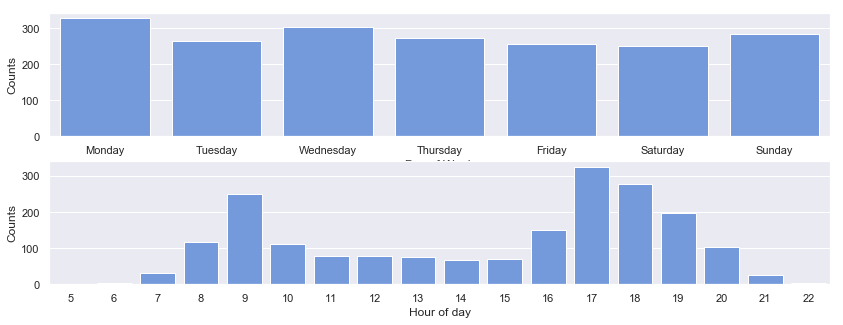

In [136]:
# prepare setting
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 5), sharex=False);
# create barplot for number of tweets by weekday
sns.barplot(data=weekday_counts,x='weekday',y='tweet_id',color='cornflowerblue', ax=ax1,order =WEEKDAYS);
ax1.set_ylabel("Counts");
ax1.set_xlabel("Day of Week");
# create barplot fo number of tweets by hour
sns.barplot(data=hour_counts,x='hour',y='tweet_id',color='cornflowerblue', ax=ax2);
ax2.set_ylabel("Counts");
ax2.set_xlabel("Hour of day");


Based on the resulting bar plot we can conclude that Monday is the top day for the dog tweets – the author(s) start the week fresh, full of energy. Then, on Wednesday we see what looks like a second breath. The least number of tweets were made on Saturday – we can suspect that the authors… have life. :)

The second bar plot shows us that the author(s) not only have life, but also have some sleep. There are no tweets in the period from 11pm to 4 pm and only a tiny amount of tweets in the periods from 10pm to 11pm and 5pm to 6pm. The most productive periods are either morning (9am-10am) – probably before work and evening – from 5pm to 7pm. 

An important thing to note here is that we would have been able to identify that pattern if we hadn’t converted the timestamp to the proper timezone when cleaning the dataset.

<a id="top_names"></a>
## Most popular dog names
[back to top](#top)

Another thing that got me interested is whether we can identify the most popular dog’s name. For that purpose I created a word cloud using wordcloud library. If we take all dog names found in these tweets, it will look as follows:

In [137]:
df.name.notnull().sum()

1345

In [138]:
len(df)

1962

In [139]:
from wordcloud import WordCloud

In [140]:
# join all names into one text
names_text = " ".join(list(df.name[df.name.notnull()]))

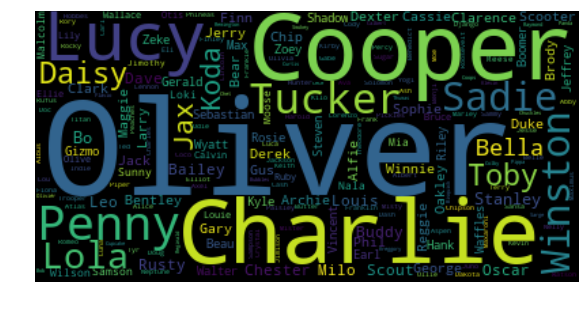

In [141]:
# create and show wordcloud
f, axw = plt.subplots(1, 1, figsize=(14, 5));
wordcloud = WordCloud(random_state=6).generate(names_text)
axw.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [142]:
df.name.value_counts().head(10)

Cooper     10
Charlie    10
Lucy       10
Oliver     10
Tucker     9 
Penny      9 
Sadie      8 
Winston    8 
Daisy      7 
Toby       7 
Name: name, dtype: int64

In [143]:
df.name.value_counts().tail(5)

Raphael     1
Berkeley    1
Quinn       1
Cedrick     1
Ziva        1
Name: name, dtype: int64

On one hand, it looks like indeed there are some top names for the dogs. To be specific, from 1345 extracted names there are 10 dogs named Oliver, 10 – Cooper, 10 – Charlie, 10 – Lucy. All other names have less than 10 counts. So in general the dog owners prefer to be original and give their pets individual  names. 

<a id="top_words"></a>
## Most popular words used in tweets
[back to top](#top)

I also created the word cloud for the most typical words used to praise dogs – i.e., the most frequent words in tweets texts.

In [144]:
# join all texts into one text
all_tweets_texts = " ".join(list(df.text[df.text.notnull()]))

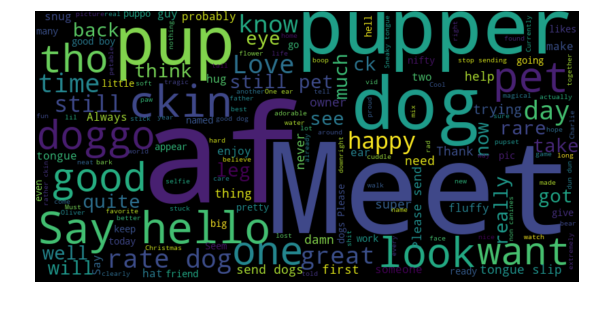

In [145]:
# create and show wordcloud
f, axw = plt.subplots(1, 1, figsize=(14, 5));
wordcloud = WordCloud(random_state=42, scale=2).generate(all_tweets_texts)
axw.imshow(wordcloud, interpolation='bilinear')
axw.axis("off")
plt.show()

When visually inspecting the data I noticed that some of the tweets contained expressions with “af”. However, I didn’t expect that it would be one of the top words! In fact, 140 tweets out of 1962 do contain “af”. 

In [146]:
df.text.str.contains(" af ").sum()

140

Some examples: 

In [147]:
df[df.text.str.contains(" af ")].text.head(10)

18     This is Ralphus. He's powering up. Attempting maximum borkdrive.  inspirational af                                                   
21     I've yet to rate a Venezuelan Hover Wiener. This is such an honor.  paw-inspiring af (IG: roxy.thedoxy)                              
49     Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds.  paw-inspiring af (IG: puffie_the_chow)         
126    This is Burt. He thinks your thesis statement is comically underdeveloped.  intellectual af                                          
132    Meet Trooper. He picks pup recyclables that have blown out of bins in the neighborhood and puts them back.  environmentally savvy af 
148    This is Marlee. She fetched a flower and immediately requested that it be placed behind her ear.  elegant af                         
172    This is Kevin. Kevin doesn't give a single h*ck. Will sit in the fountain if he wants to.  churlish af                               
184    This i

<a id="top_predictions"></a>
## Most popular dog breed
[back to top](#top)

It's also interesting to check what are the most popular dog breed posted on this Twitter account. I'm using only the first prediction because it has the highest confidence. 

In [148]:
all_predictions = list(df[df.p1_dog].p1)
# show top 10 value counts for predictions
all_predictions_series = pd.Series(all_predictions)
all_predictions_series.value_counts().head(10)

Golden retriever      136
Labrador retriever    94 
Pembroke              87 
Chihuahua             78 
Pug                   54 
Chow                  41 
Samoyed               39 
Pomeranian            38 
Toy poodle            37 
Malamute              29 
dtype: int64

In [149]:
((all_predictions_series=='Labrador retriever')|(all_predictions_series=='Golden retriever')).sum()/len(df)

0.11722731906218145

In [150]:
(all_predictions_series=="Chihuahua").sum()/len(df)

0.039755351681957186

In [151]:
(all_predictions_series=="Pembroke").sum()/len(df)

0.04434250764525994

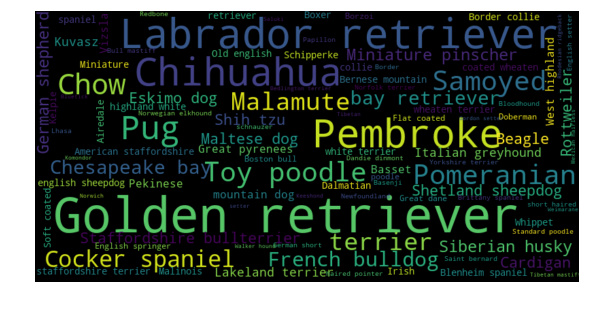

In [152]:
# create and show wordcloud
f, axw = plt.subplots(1, 1, figsize=(14, 5));
wordcloud = WordCloud(random_state=6, max_words=100, scale=2).generate(",".join(all_predictions))
axw.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Looks like labrador retriever and golden retriever are top posted dogs - in fact, 12% of all predictions that predict a dog also predict that it's a retriever!

### Most popular rating
[back to top](#top)

Since the whole Twitter account is about dog rates we couldn’t avoid comparing the ratings. I decided to create a bar plot for ratings in the “normal” range from 1/10 to 20/10. Everything above that range are normally puppies where rating is scaled by the number of puppies (for example 88/80) or some special dogs (e.g. 1776/10 – the Declaration of Independence dog)

In [153]:
# get number of tweets per rating numerator (excluding puppies and other outliers)
rating_counts = df[df.rating_numerator < 20][['rating_numerator','tweet_id']].groupby('rating_numerator', as_index=False).count()

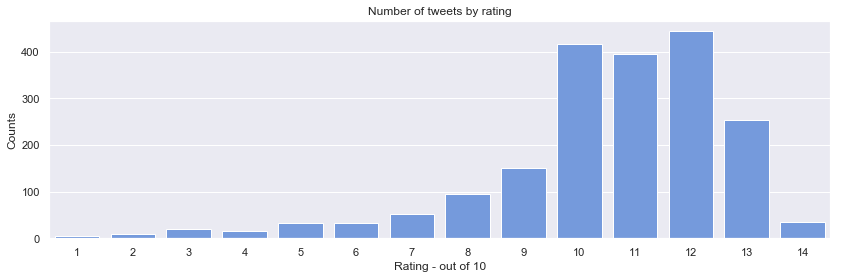

In [154]:
# create barplot for number of tweets by rating
f, ax = plt.subplots(1, 1, figsize=(14, 4));
sns.barplot(data=rating_counts,x='rating_numerator',y='tweet_id',color='cornflowerblue', ax=ax);
ax.set_ylabel("Counts");
ax.set_xlabel("Rating - out of 10");
ax.set_title("Number of tweets by rating");

Looks like most dogs are rated from 10/10 to 13/10. Because most dogs are “good dogs, Brent”. Some low rating are due to the fact that it’s not a dog at all, but we couldn’t filter them out because the predictions were wrong in too many cases. 

### Distribution of likes and retweets
[back to top](#top)

Typically, such thins as number of likes and shares have right-skewed distribution and we expect to see something similar here. Let's check if that's correct.

In [155]:
pd.concat([pd.DataFrame(df.retweet_count.describe()), 
           pd.DataFrame(df.favorite_count.describe())],axis=1)

,retweet_count,favorite_count
count,1962.000000,1962.000000
mean,2646.267074,8732.332824
std,4721.355436,12809.265378
min,11.000000,77.000000
25%,590.250000,1888.750000
50%,1271.500000,3935.000000
75%,3023.000000,10881.750000
max,83113.000000,163464.000000


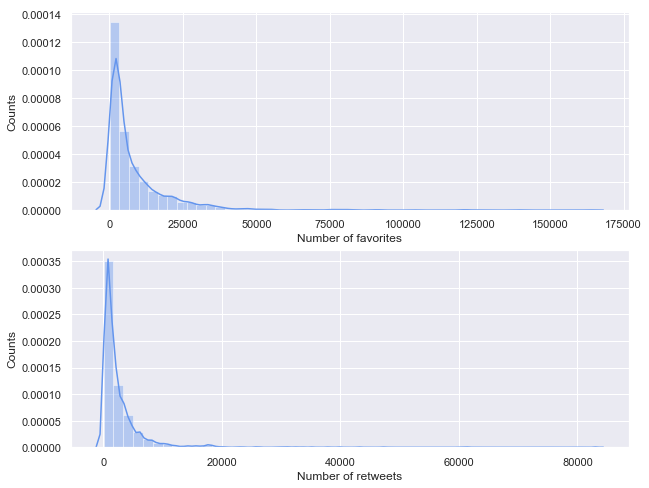

In [156]:
# prepare setting
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=False);
# plot distribution of favorite counts
sns.distplot(df.favorite_count,color='cornflowerblue', ax=ax1);
ax1.set_ylabel("Counts");
ax1.set_xlabel("Number of favorites");
# plot distribution of number of retweets
sns.distplot(df.retweet_count,color='cornflowerblue', ax=ax2);
ax2.set_ylabel("Counts");
ax2.set_xlabel("Number of retweets");

And indeed - no surprises here. Right-skewed with highest peak on the left. This is the normal picture. We could have transformed it to normal-looking distribution using log-scale, but it doesn't look like we can get anything interesting here.

### Number of retweets vs number of favorites
[back to top](#top)

I also decided to look at various relationships between variables, but the only strong one I was able to discover was the most obvious one – between the number of favorites and the number of retweets with correlation coefficient of 0.93.

In [157]:
import numpy as np

In [158]:
np.corrcoef(df.retweet_count, df.favorite_count)

array([[1.        , 0.93026303],
       [0.93026303, 1.        ]])

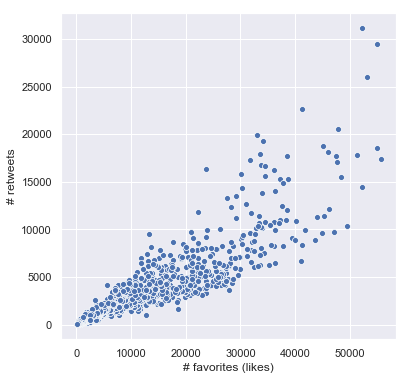

In [159]:
f, ax = plt.subplots(1, 1, figsize=(6, 6));
sns.scatterplot(x='favorite_count', y='retweet_count',
                data=df[(df.favorite_count<60000)&(df.retweet_count<40000)&(df.rating_numerator<20)]);
ax.set_xlabel("# favorites (likes)");
ax.set_ylabel("# retweets");

### Average Number of Favorites by Dog Stage
[back to top](#top)

Some tweets also contain information about the dog stage. It’s one of doggo, floofer, pupper or puppo. It’s important to note there, that only 328 tweets where the dog stage is explicitly named. For these dogs – what dog stages get more favorites on average?

In [160]:
df.dog_stage.notnull().sum()

328

In [161]:
stage_favorite_counts = df[df.dog_stage.notnull()][['dog_stage', 'favorite_count']]
stage_favorite_counts_agg = stage_favorite_counts.groupby('dog_stage', as_index=False).mean()

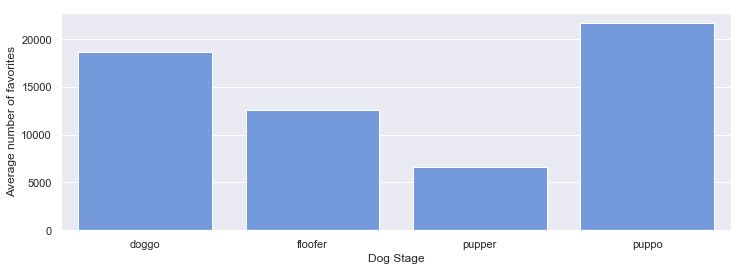

In [162]:
f, ax = plt.subplots(1, 1, figsize=(12, 4));
sns.barplot(data=stage_favorite_counts_agg,x='dog_stage',y='favorite_count',color='cornflowerblue', ax=ax);
ax.set_ylabel("Average number of favorites");
ax.set_xlabel("Dog Stage");

We can notice that puppo is by far the most liked stage of the dog followed by doggo. However, we can’t make any broad conclusions here given that only a tiny fraction of dogs have the stage identified.

<a id="conclusion"></a>
# Conclusion 
[back to top](#top)

In this analysis we did some basic exploratory data analysis that allowed us to understand the general characteristics of the majority of the tweets. We discovered that WeRateDogs twitter typically tweets in the intervals of 9-10am or 5-7pm and that Monday is the most productive day in terms of twitting. 

We also found out that dog owner don’t like to give their pets too common names, but when it comes to praising dogs, a lot of post start with “Meet”, “look” and describe the dog with the characteristic ending with “af”. And we also found out that most ratings are in the interval from 10/10 to 13/10.
    
Some ideas regarding future analysis can include trying to predict the dog stage both from text and from the picture. It can also be interesting to perform the sentiment analysis of the tweets, although the word cloud suggest that most of the tweets will have mostly positive sentiment polarity. Other text characteristics like text length, number of words are likely to be irrelevant (see  my [exploration of online news in Project 6](https://github.com/AnaMakarevich/DAND/blob/master/Projects/Project_6_OnlineNewsPopularity/OnlineNewsPopularityAnalysis.md)).

# References
[back to top](#top)

- https://stackoverflow.com/questions/25351968/how-to-display-full-non-truncated-dataframe-information-in-html-when-convertin

- https://stackoverflow.com/questions/30088006/loading-a-file-with-more-than-one-line-of-json-into-pythons-pandas
- https://stackoverflow.com/questions/35491274/pandas-split-column-of-lists-into-multiple-columns
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html  
- http://www.learnersdictionary.com/qa/parts-of-the-day-early-morning-late-morning-etc  
- https://seaborn.pydata.org/examples/color_palettes.html